In [1]:
import pandas as pd
import numpy as np
import spacy
from textblob import TextBlob

from statistics import mean, stdev
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

from sklearn.preprocessing import binarize

In [2]:
data = pd.read_csv("project_18_dataset_combined.csv")
data = data[['label', 'text']]

#set display option
pd.set_option('display.max_colwidth', None)

#make target labels boolean
data['label']=data['label'].apply(lambda x: 1 if x == 14 else 0)

In [3]:
print(data.shape)
print(data.label.value_counts())
data.head()

(19821, 2)
0    18585
1     1236
Name: label, dtype: int64


,label,text
0,0,"Serious Youth Violence crimes, lone wolves basically."
1,0,Yesterday?
2,0,"I would argue with you, but it seems pointless. If I understand you, your argument is this: the UK can do whatever it wants the UK is never wrong"
3,0,"the whole thing is pretty dumb desu, school kids could be in a class of 12 or whatever all mingling and thats fine, but if they leave school and they all go to the park then thats not not allowed"
4,0,"I fucking hope you re right, lad."


In [4]:
#Balancing data
count_label_0, count_label_1 = data.label.value_counts()

data_label_1 = data[data['label'] == 1]
data_label_0 = data[data['label'] == 0]

data_label_0_b = data_label_0.sample(count_label_1, random_state=88)
data_b = pd.concat([data_label_0_b, data_label_1])
print(data_b.shape)
print(data_b.label.value_counts())
data_b.head()

(2472, 2)
0    1236
1    1236
Name: label, dtype: int64


,label,text
17921,0,pointing out the ruse is lower IQ than the people who just sit back and enjoy the show
17572,0,I am in bed dingus I am going to sleep Do not summon me again
15394,0,boy he just has the worst opinions about everything. But is he also the anti-awoo beaner?
19111,0,DAY OF THE RAKE!
189,0,Is it Constantine filming from the hell dimension?


In [199]:
#!pip3 install -U spacy

In [200]:
#!python3 -m spacy download en_core_web_sm

In [5]:
#lemmatizing
nlp = spacy.load('en_core_web_sm')
data_b['text_lemmatized'] = data_b['text'].apply(lambda x: " ".join([words.lemma_ for words in nlp(x)]))

C:\Users\phill\anaconda3\lib\site-packages\spacy\util.py:833: UserWarning: [W095] Model 'en_core_web_sm' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.2.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [6]:
#train/test splitting again
X_train, X_test, y_train, y_test = train_test_split(data_b.text_lemmatized, data_b.label, test_size=0.25, random_state=14, stratify=data_b.label)

In [7]:
#calculating accuracy, precison and roc_auc between models with default and tuned parameters
#set best parameters in cv/tfid pipeline for comparison

pipeline_old = Pipeline([ ('vectorizer', TfidfVectorizer()), ('classifier', MultinomialNB()) ])
tfid_pipeline = Pipeline([ ('vectorizer', TfidfVectorizer(lowercase=True, max_df=0.3, min_df=2, ngram_range=(1, 5), smooth_idf=True, sublinear_tf=True, use_idf=False)), ('classifier', MultinomialNB(alpha=0.1, fit_prior=True)) ])

model_old = pipeline_old.fit(X_train, y_train)
tfid_model = tfid_pipeline.fit(X_train, y_train)

y_pred_class_old = model_old.predict(X_test)
tfid_y_pred_class = tfid_model.predict(X_test)

print('accuracy score before tuning model:', accuracy_score(y_test, y_pred_class_old))
print('TFID accuracy score after tuning:', accuracy_score(y_test, tfid_y_pred_class))
print('-----')
print('precision score before tuning:', precision_score(y_test, y_pred_class_old))
print('TFID precision score after tuning:', precision_score(y_test, tfid_y_pred_class))
print('-----')
print('recall score before tuning:', recall_score(y_test, y_pred_class_old))
print('TFID recall score after tuning:', recall_score(y_test, tfid_y_pred_class))

accuracy score before tuning model: 0.7022653721682848
TFID accuracy score after tuning: 0.7847896440129449
-----
precision score before tuning: 0.6349892008639308
TFID precision score after tuning: 0.7619047619047619
-----
recall score before tuning: 0.9514563106796117
TFID recall score after tuning: 0.8284789644012945


In [8]:
#comparing confusing matrices
print('old model cm:')
print(confusion_matrix(y_test, y_pred_class_old))
print('new model cm:')
print(confusion_matrix(y_test, tfid_y_pred_class))

old model cm:
[[140 169]
 [ 15 294]]
new model cm:
[[229  80]
 [ 53 256]]


In [9]:
#train/test splitting again
X_train, X_test, y_train, y_test = train_test_split(data_b.text_lemmatized, data_b.label, test_size=0.25, random_state=14, stratify=data_b.label)

#remember to set parameters
pipeline = Pipeline([ ('vectorizer', TfidfVectorizer(lowercase=True, max_df=0.3, min_df=2, ngram_range=(1, 5), smooth_idf=True, sublinear_tf=True, use_idf=False)), ('classifier', MultinomialNB(alpha=0.1, fit_prior=True)) ])

model = pipeline.fit(X_train, y_train)

y_pred_class = model.predict(X_test)

In [10]:
#see false positive comments
#false_positives = pd.DataFrame({'false_positives': X_test[(y_pred_class==1) & (y_test==0)]})
#print(false_positives.shape)
#false_positives

In [17]:
#see false negative comments
#false_negatives = pd.DataFrame({'false_negatives': X_test[(y_pred_class==0) & (y_test==1)]})
#print(false_negatives.shape)
#false_negatives

In [11]:
vectorizer = TfidfVectorizer(lowercase=True, max_df=0.3, min_df=2, ngram_range=(1, 5), smooth_idf=True, sublinear_tf=True, use_idf=False)

all_features = vectorizer.fit_transform(data_b.text_lemmatized)
all_features

print(len(vectorizer.get_feature_names()))
print(all_features.shape)

mnb = MultinomialNB(alpha=0.1, fit_prior=False)

X_train_dtm = vectorizer.fit_transform(X_train)
X_test_dtm = vectorizer.transform(X_test)

model_test = mnb.fit(X_train_dtm, y_train)

24092
(2472, 24092)


In [12]:
# store the vocabulary of X_train
X_train_tokens = vectorizer.get_feature_names()

# number of times each token appears across all history comments
hisco_token_count = mnb.feature_count_[1, :]

# number of times each token appears across all non-history comments
nhisco_token_count = mnb.feature_count_[0, :]

In [13]:
# create a DataFrame of tokens with their separate his and non-his counts
tokens = pd.DataFrame({'token':X_train_tokens, 'non_history':nhisco_token_count, 'history':hisco_token_count}).set_index('token')

# add 1 to each label counts to avoid dividing by 0
tokens['non_history'] = tokens.non_history + 1
tokens['history'] = tokens.history + 1

# convert his and non-his counts into frequencies
tokens['non_history'] = tokens.non_history / mnb.class_count_[0]
tokens['history'] = tokens.history / mnb.class_count_[1]

# calculate the ratio of his-to-non-his for each token
tokens['history_ratio'] = tokens.history / tokens.non_history

# calculate the ratio of non-his-to-his for each token
tokens['non_history_ratio'] = tokens.non_history / tokens.history

In [14]:
# examine the DataFrame sorted by history_comments_ratio
tokens_his = tokens.sort_values('history_ratio', ascending=False)
tokens_his[:25]

,non_history,history,history_ratio,non_history_ratio
token,,,,
hitler,0.001079,0.014833,13.750522,0.072725
history,0.002015,0.013847,6.870380,0.145552
rome,0.001079,0.006705,6.215442,0.160890
century,0.001079,0.006058,5.615775,0.178070
catholic,0.001079,0.005211,4.830672,0.207011
pyramid,0.001079,0.004996,4.631657,0.215905
holocaust,0.001079,0.004914,4.555674,0.219507
ancient,0.001129,0.005088,4.505319,0.221960
germany,0.001767,0.007704,4.359318,0.229394


In [15]:
# examine the DataFrame sorted by non_history_comments_ratio
tokens_non_his = tokens.sort_values('non_history_ratio', ascending=False)
tokens_non_his[:25]

,non_history,history,history_ratio,non_history_ratio
token,,,,
biden,0.004403,0.001079,0.244979,4.081985
virus,0.005058,0.001613,0.318945,3.135338
tfw,0.003367,0.001079,0.320427,3.120838
kek,0.008526,0.002774,0.325309,3.073997
she,0.008961,0.003087,0.344513,2.902646
her,0.005493,0.002020,0.367840,2.718574
death,0.004475,0.001705,0.381028,2.624480
test,0.002824,0.001079,0.382016,2.617692
make you,0.002692,0.001079,0.400673,2.495801


In [16]:
tokens.loc['morning', 'history_ratio']

0.6442274216584546

In [247]:
#print(len(data_b[data_b.text_lemmatized.str.contains('steal')]))

#print(data_b.text[data_b.text_lemmatized.str.contains('steal')])

In [17]:
y_pred_prob = model.predict_proba(X_test)[:, 1]

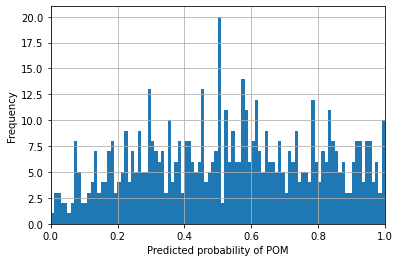

In [21]:
plt.hist(y_pred_prob, bins=100)
plt.xlim(0, 1)
plt.xlabel('Predicted probability of POM')
plt.ylabel('Frequency')

plt.grid(True)

In [22]:
comment_proba = pd.DataFrame({'comment':X_test, 'pred_proba':y_pred_prob, 'pred_class':y_pred_class})

In [23]:
sorted_proba = comment_proba.sort_values('pred_proba', ascending=False)

In [24]:
comment_proba.loc[(comment_proba['pred_proba'] == 0.5)]

,comment,pred_proba,pred_class
15059,uncle bumblefuck watcher .,0.5,0
621,I m laffin,0.5,0
8650,GIGACOPE,0.5,0
3533,s,0.5,0
5450,nope,0.5,0
13142,cute ngl,0.5,0
9990,1889,0.5,0
15665,SHO SHO,0.5,0
17034,yoooooooooo,0.5,0
3553,s,0.5,0


In [25]:
sorted_proba.head(50)

,comment,pred_proba,pred_class
43,"today in history : ( 1/2 ) – Eastern Roman Emperor Constans II be assassinate in his bath at Syracuse , Italy . – Major Fatimid victory over the Byzantine Empire at the Battle of the Orontes . 1440 – Gilles de Rais , one of the early know serial killer , be take into custody upon an accusation bring against he by Jean de Malestroit , Bishop of Nantes . 1556 – depart from Vlissingen , ex - holy Roman Emperor Charles V return to Spain . 1762 – seven Years War : Battle of Signal Hill . 1776 – American Revolutionary War : british force land at Kip s Bay during the New York Campaign . 1794 – French Revolutionary Wars : Arthur Wellesley ( later Duke of Wellington ) see his first combat at the Battle of Boxtel during the Flanders Campaign . 1795 – Britain seize the dutch Cape Colony in southern Africa to prevent its use by the Batavian Republic . 1812 – the Grande Armée under Napoleon reach the Kremlin in Moscow . 1812 – war of 1812 : a second supply train send to relieve Fort Harrison be ambush in the Attack at the Narrows . 1820 – constitutionalist revolution in Lisbon , Portugal . 1821 – the Captaincy General of Guatemala declare independence from Spain . 1830 – the Liverpool to Manchester railway line open british MP William Huskisson become the first widely report railway passenger fatality when he be strike and kill by the locomotive Rocket .",0.998799,1
3139,"Eugenio Pacelli , Pius XII , be one of the few unalloyed hero of World War II . at great personal risk , he save some 800,000 Jews from extermination by the Nazis . jewish refugee be give asylum in the Vatican , swell the number of Swiss Guards . no allied leader can match his glorious record . Golda Meir laud Pius XII after the war , and the chief rabbi of Rome become a roman Catholic , take the name of Eugenio in tribute to Eugenio Pacelli . why then have such a man be vilify and all but accuse of be responsible for the Holocaust ? Rolf Hochhuth s infamous play , the Deputy , mark the turning point . the outrageous distortion of this play turn the great friend the jewish people have during World War II into an anti - semite . this book restore Pius XII to the rank of hero , demolish the ludicrous charge against he , and identify the true target of this infamous calumny : the Church , the papacy , and the christian moral teaching which confront and condemn the Culture of Death .",0.998410,1
7937,动态网自由门 天安門 天安门 法輪功 李洪志 Free Tibet 六四天安門事件 the Tiananmen Square protest of 1989 天安門大屠殺 the Tiananmen Square Massacre 反右派鬥爭 the Anti - rightist Struggle 大躍進政策 the Great Leap Forward 文化大革命 the Great Proletarian Cultural Revolution 人權 Human Rights 民運 Democratization 自由 Freedom 獨立 Independence 多黨制 multi - party system 台灣 臺灣 Taiwan Formosa 中華民國 Republic of China 西藏 土伯特 唐古特 Tibet 達賴喇嘛 Dalai Lama 法輪功 Falun Dafa 新疆維吾爾自治區 the Xinjiang Uyghur Autonomous Region 諾貝爾和平獎 Nobel Peace Prize 劉暁波 Liu Xiaobo 民主 言論 思想 反共 反革命 抗議 運動 騷亂 暴亂 騷擾 擾亂 抗暴 平反 維權 示威游行 李洪志 法輪大法 大法弟子 強制斷種 強制堕胎 民族淨化 人體實驗 肅清 胡耀邦 趙紫陽 魏京生 王丹 還政於民 和平演變 激流中國 北京之春 大紀元時報 九評論共産黨 獨裁 專制 壓制 統一 監視 鎮壓 迫害 侵略 掠奪 破壞 拷問 屠殺 活摘器官 誘拐 買賣人口 遊進 走私 毒品 賣淫 春畫 賭博 六合彩 天安門 天安门 法輪功 李洪志 Winnie the Pooh 劉曉波动态网自由门,0.998353,1
9221,"do anyone still believe the Constitution be some great work of civic ? the first and second amendment be the only one worth a crap , and I do give they credit for that , but literally everything else about the government the Founding Fathers set up be a pile of shit . and only year later , with a civil war in the middle , the 1st and 2nd have be completely subvert . have /pol/ ever read any of their writing ? Thomas Jefferson say it would be ok if mohammedian come and set up their own community in America . George Washington say similar cucky thing about America be a place all race could live . the fact be the only reason America be a super power be because it be a virgin continent with completely untouched natural resource . it have nothing to do with the found anglo stock and the brilliance of the Fou

In [26]:
sorted_proba.tail(50)

,comment,pred_proba,pred_class
4402,"go back to \tv/ faggot , reality be nt a sci - fi movie .",0.151333,0
2993,"with any chick , just fucking chat it up and be genuine . we get ta just b urself poster guy !",0.149911,0
11327,Kek,0.142218,0
17534,Kek,0.142218,0
7208,kek,0.142218,0
3236,depend upon what part of India . Wife s doctor be northern Indian and she be the most perfect human I have ever see . no cosmetic and she be exquisite .,0.138539,0
1740,Oy vey !,0.135774,0
11922,what s everyone s take on the ... poll ? it s fake and gay like your neo - vagina .,0.135424,0
15652,"shut up leaf , you ll have even less test kit than we .",0.134654,0
9913,oh do they catch DB Cooper ? I miss that news .,0.133815,0


In [27]:
sorted_proba['characters'] = sorted_proba['comment'].str.len()

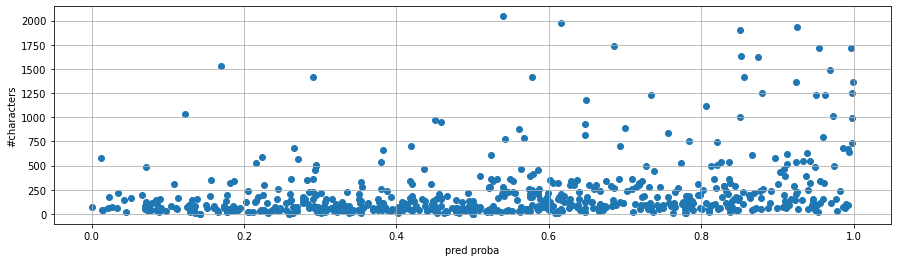

In [28]:
plt.figure(figsize=(15,4))
plt.scatter(sorted_proba['pred_proba'], sorted_proba['characters'])
plt.xlabel('pred proba')
plt.ylabel('#characters')
plt.grid(True)

In [29]:
sorted_proba['words'] = [len(x.split()) for x in sorted_proba['comment'].tolist()]

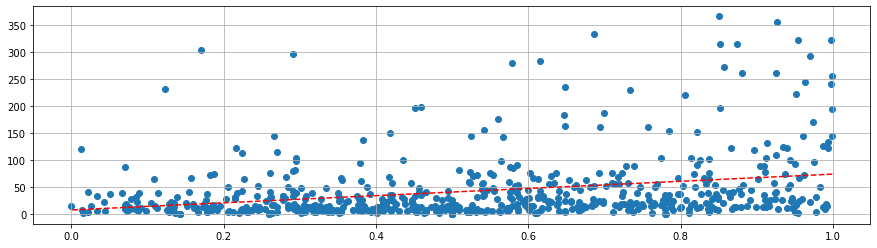

In [30]:
plt.figure(figsize=(15,4))
x = sorted_proba['pred_proba']
y = sorted_proba['words']
plt.scatter (x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x), "r--")

plt.grid(True)
plt.show()

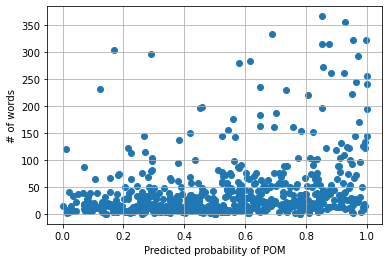

In [36]:
plt.figure()
plt.scatter(sorted_proba['pred_proba'], sorted_proba['words'])
plt.xlabel('Predicted probability of POM')
plt.ylabel('# of words')

from sklearn.metrics import r2_score

plt.grid(True)
plt.show()

In [194]:
print('average # of characters in pred comments:', sorted_proba.characters.mean())
print('average # of word in pred comments:', sorted_proba.words.mean())
print('-----')
print('average # of characters in pos pred comments:', sorted_proba.characters[sorted_proba['pred_class'] == 1].mean())
print('average # of characters in neg pred comments:', sorted_proba.characters[sorted_proba['pred_class'] == 0].mean())
print('-----')
print('average # of words in pos pred comments:', sorted_proba.words[sorted_proba['pred_class'] == 1].mean())
print('average # of words in neg pred comments:', sorted_proba.words[sorted_proba['pred_class'] == 0].mean())
print('-----')
print('average # of characters with pos pred_proba above 90%:', sorted_proba.characters[sorted_proba['pred_proba'] >= 0.9].mean())
print('average # of characters with pos pred_proba below 90%:', sorted_proba.characters[sorted_proba['pred_proba'] < 0.9].mean())
print('-----')
print('average # of words with pos pred_proba above 90%:', sorted_proba.words[sorted_proba['pred_proba'] >= 0.9].mean())
print('average # of words with pos pred_proba below 10%:', sorted_proba.words[sorted_proba['pred_proba'] <= 0.1].mean())

average # of characters in pred comments: 220.31877022653723
average # of word in pred comments: 43.75889967637541
-----
average # of characters in pos pred comments: 292.95575221238937
average # of characters in neg pred comments: 132.0609318996416
-----
average # of words in pos pred comments: 56.97935103244838
average # of words in neg pred comments: 27.695340501792113
-----
average # of characters with pos pred_proba above 90%: 472.6825396825397
average # of characters with pos pred_proba below 90%: 191.67207207207207
-----
average # of words with pos pred_proba above 90%: 90.82539682539682
average # of words with pos pred_proba below 10%: 23.620689655172413


In [133]:
X_train, X_test, y_train, y_test = train_test_split(data_b.text_lemmatized, data_b.label, test_size=0.25, random_state=14, stratify=data_b.label)

pipeline_old = Pipeline([ ('vectorizer', TfidfVectorizer()), ('classifier', MultinomialNB()) ])
tfid_pipeline = Pipeline([ ('vectorizer', TfidfVectorizer(lowercase=True, max_df=0.4, min_df=2, ngram_range=(1, 5), smooth_idf=True, sublinear_tf=True, use_idf=False)), ('classifier', MultinomialNB(alpha=0.1, fit_prior=False)) ])

model_old = pipeline_old.fit(X_train, y_train)
tfid_model = tfid_pipeline.fit(X_train, y_train)

y_pred_prob_old = model_old.predict_proba(X_test)[:, 1]
y_pred_prob = tfid_model.predict_proba(X_test)[:, 1]

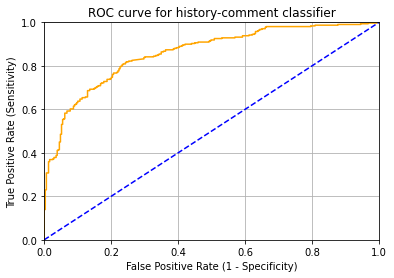

In [134]:
#ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, color='orange')
plt.plot([0,1],[0,1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for history-comment classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

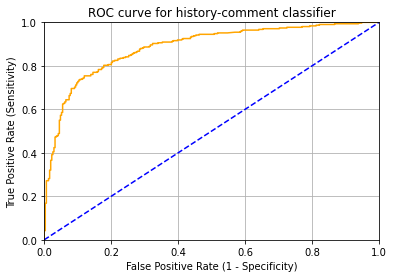

In [135]:
#ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_old)
plt.plot(fpr, tpr, color='orange')
plt.plot([0,1],[0,1], color='blue', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for history-comment classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

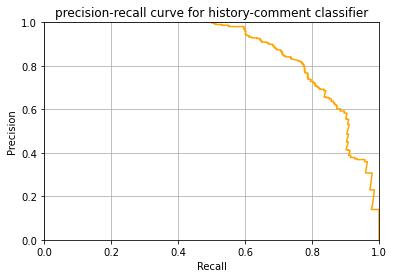

In [136]:
#precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(precision, recall, color='orange')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('precision-recall curve for history-comment classifier')
plt.xlabel('Recall') #or is it reverse????
plt.ylabel('Precision')
plt.grid(True)

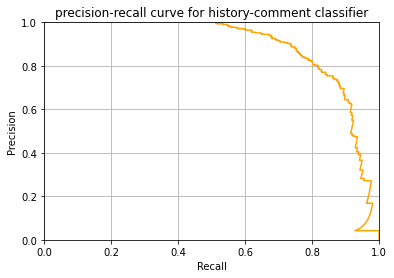

In [137]:
#precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob_old)
plt.plot(precision, recall, color='orange')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('precision-recall curve for history-comment classifier')
plt.xlabel('Recall') #or is it reverse????
plt.ylabel('Precision')
plt.grid(True)